<a href="https://colab.research.google.com/github/gibranfp/CursoAprendizajeProfundo/blob/2024-1/notebooks/0c_cargadores_datos_pytorch_completo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cargadores de datos
PyTorch ofrece funciones, clases y herramientas para llevar a cabo eficientemente la extracción, carga, preprocesamiento y generación de lotes de conjuntos de datos de diversa índole (ver [DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)).

![PyTorch DataLoaders](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fb0SVvH%2FbtqLq2FmuEs%2F1hnCz8VL9wvXPKTOTXzvOk%2Fimg.jpg)

Fuente: [https://jackyoon5737.tistory.com/203](https://jackyoon5737.tistory.com/203).

In [1]:
import torch as th
from torch import nn

import numpy as np
import matplotlib.pyplot as plt

# Por reproducibilidad
th.manual_seed(42)
np.random.seed(42)

N_IMGS_MUESTRA = 16
T_LOTE = 32
T_IMAGEN = 64

## Conjunto de imágenes Fruits 360
Usaremos un conjunto de imágenes de frutas llamado *Fruits 360*, el cual está compuesto por imágenes a color de $100 \times 100 \times 3$ de 131 frutas distintas. Para descargar este conjunto de imágenes simplemente clonamos el repositorio de [GitHub](https://github.com/Horea94/Fruit-Images-Dataset).

In [2]:
!git clone https://github.com/Horea94/Fruit-Images-Dataset.git

Cloning into 'Fruit-Images-Dataset'...
remote: Enumerating objects: 385858, done.
remote: Counting objects: 100% (8693/8693), done.
remote: Compressing objects: 100% (8659/8659), done.
remote: Total 385858 (delta 37), reused 8688 (delta 34), pack-reused 377165
Receiving objects: 100% (385858/385858), 2.10 GiB | 27.80 MiB/s, done.
Resolving deltas: 100% (1197/1197), done.
Updating files: 100% (90503/90503), done.


La estructura del repositorio clonado es la siguiente:

In [3]:
!ls Fruit-Images-Dataset/

LICENSE  papers  readme.md  src  Test  test-multiple_fruits  Training


El directorio principal contiene los directorios `Training` y `Test`. Examinamos el contenido de ambos.

In [4]:
!ls Fruit-Images-Dataset/Training
!ls Fruit-Images-Dataset/Test

'Apple Braeburn'       'Grape Blue'	     'Pear Monster'
'Apple Crimson Snow'   'Grapefruit Pink'     'Pear Red'
'Apple Golden 1'       'Grapefruit White'    'Pear Stone'
'Apple Golden 2'       'Grape Pink'	     'Pear Williams'
'Apple Golden 3'       'Grape White'	      Pepino
'Apple Granny Smith'   'Grape White 2'	     'Pepper Green'
'Apple Pink Lady'      'Grape White 3'	     'Pepper Orange'
'Apple Red 1'	       'Grape White 4'	     'Pepper Red'
'Apple Red 2'	        Guava		     'Pepper Yellow'
'Apple Red 3'	        Hazelnut	      Physalis
'Apple Red Delicious'   Huckleberry	     'Physalis with Husk'
'Apple Red Yellow 1'    Kaki		      Pineapple
'Apple Red Yellow 2'    Kiwi		     'Pineapple Mini'
 Apricot	        Kohlrabi	     'Pitahaya Red'
 Avocado	        Kumquats	      Plum
'Avocado ripe'	        Lemon		     'Plum 2'
 Banana		       'Lemon Meyer'	     'Plum 3'
'Banana Lady Finger'    Limes		      Pomegranate
'Banana Red'	        Lychee		     'Pomelo Sweetie'
 Beetroot	        Mand

Tanto `Training` como `Test` contienen a su vez subdirectorios con nombres de frutas y vegetales. Veamos un par de estos:

In [5]:
!ls Fruit-Images-Dataset/Training/Cocos
!ls Fruit-Images-Dataset/Test/Cocos

100_100.jpg  194_100.jpg  51_100.jpg	 r_19_100.jpg	r_28_100.jpg
101_100.jpg  195_100.jpg  52_100.jpg	 r_191_100.jpg	r_281_100.jpg
102_100.jpg  196_100.jpg  53_100.jpg	 r_192_100.jpg	r_282_100.jpg
103_100.jpg  197_100.jpg  54_100.jpg	 r_193_100.jpg	r_283_100.jpg
104_100.jpg  198_100.jpg  55_100.jpg	 r_194_100.jpg	r_284_100.jpg
105_100.jpg  199_100.jpg  56_100.jpg	 r_195_100.jpg	r_285_100.jpg
106_100.jpg  200_100.jpg  57_100.jpg	 r_196_100.jpg	r_286_100.jpg
107_100.jpg  20_100.jpg   58_100.jpg	 r_197_100.jpg	r_287_100.jpg
108_100.jpg  201_100.jpg  59_100.jpg	 r_198_100.jpg	r_288_100.jpg
109_100.jpg  202_100.jpg  60_100.jpg	 r_199_100.jpg	r_289_100.jpg
110_100.jpg  203_100.jpg  61_100.jpg	 r_200_100.jpg	r_290_100.jpg
111_100.jpg  204_100.jpg  62_100.jpg	 r_20_100.jpg	r_29_100.jpg
112_100.jpg  205_100.jpg  63_100.jpg	 r_201_100.jpg	r_291_100.jpg
113_100.jpg  206_100.jpg  64_100.jpg	 r_202_100.jpg	r_292_100.jpg
114_100.jpg  207_100.jpg  65_100.jpg	 r_203_100.jpg	r_293_100.jpg
115_100.jpg  2

Este conjunto se encuentra dividido en subconjuntos de entrenamiento y prueba, los cuales están contenidos en los subdirectorios `Training` y `Test`. A su vez, estos subdirectorios contienen un directorio por cada clase de fruta y dentro de cada uno de ellos están las imágenes correspondientes. Vamos a recopilar la ruta de cada una de estas imágenes con su correspondiente etiqueta. Para ello definiremos la función `carga_db` que recibe como argumentos la ruta del directorio principal (`Training` o `Test`) donde se encuentran y un diccionario que mapea la cadena del nombre de cada fruta a un entero y regresa la lista de rutas de todas las imágenes, la lista de nombres de frutas (etiquetas) y la lista de categorías. Usaremos la función `listdir` del módulo [`os`](https://docs.python.org/es/3.10/library/os.html) para listar el contenido del directorio principal y de cada uno de los subdirectorios que contienen las imágenes.

In [6]:
import os

def carga_bd(ruta, str_a_ind):
  imgs = []
  etiqs = []
  cats = []
  for e in os.listdir(ruta): # cada subdirectorio (nombre de fruta)
    for f in os.listdir(ruta + '/' + e): # cada archivo en subdirectorio
      imgs.append(ruta + '/' + e + '/' + f) # guarda ruta completa de imagen
      etiqs.append(e) # nombre de fruta
      cats.append(str_a_ind[e]) # categoría asociada a nombre de fruta

  return imgs, etiqs, cats

Especificamos las rutas de los subconjuntos de entrenamiento y prueba y listamos el contenido del directorio `Training` (el  cual contiene un subdirectorio por cada fruta) usando la función `listdir` del módulo `os`.

In [7]:
ruta_ent = 'Fruit-Images-Dataset/Training'
ruta_prueba = 'Fruit-Images-Dataset/Test'

dirs_ent = os.listdir(ruta_ent)

Generamos un diccionario que mapea la cadena de cada nombre de fruta a un entero y otro diccionario para hacer el mapeo inverso.

In [8]:
ind_a_str = {i:s for i,s in enumerate(dirs_ent)}
str_a_ind = {s:i for i,s in enumerate(dirs_ent)}

Cargamos los conjuntos de entrenamiento y prueba usando la función `carga_db`.

In [9]:
img_ent, etiq_ent, cat_ent = carga_bd(ruta_ent, str_a_ind)
img_prueba, etiq_prueba, cat_prueba = carga_bd(ruta_prueba, str_a_ind)

Ya descargadas las imágenes, podemos visualizar algunas:

Ahora inspeccionémos el número de imágenes y el número de clases en el conjunto de entrenamiento:

In [10]:
n_clases = len(dirs_ent)
n_ej = len(img_ent)
n_prueba = len(img_prueba)

print(f'Número de clases = {n_clases}\nNúmero de ejemplos en entrenamiento = {n_ej}')
print(f'Número de ejemplos en prueba = {n_prueba}')

Número de clases = 131
Número de ejemplos en entrenamiento = 67692
Número de ejemplos en prueba = 22688


Construimos un `DataFrame` de Pandas del conjunto de entrenamiento usando una lista generada al aplicar la función `zip` de Python a la lista de imágenes, la lista de etiquetas y la lista de categorías.

In [11]:
import pandas as pd

df_ent = pd.DataFrame(list(zip(img_ent, etiq_ent, cat_ent)),
                      columns =['Archivo', 'Etiqueta', 'Categoría'])
df_ent.sample(10)

,Archivo,Etiqueta,Categoría
21874,Fruit-Images-Dataset/Training/Apple Braeburn/r...,Apple Braeburn,41
67509,Fruit-Images-Dataset/Training/Cauliflower/134_...,Cauliflower,130
48375,Fruit-Images-Dataset/Training/Tangelo/22_100.jpg,Tangelo,93
60571,Fruit-Images-Dataset/Training/Tomato 1/290_100...,Tomato 1,118
3292,Fruit-Images-Dataset/Training/Kaki/82_100.jpg,Kaki,6
58710,Fruit-Images-Dataset/Training/Grape Blue/607_1...,Grape Blue,114
25799,Fruit-Images-Dataset/Training/Apple Golden 2/1...,Apple Golden 2,49
7220,Fruit-Images-Dataset/Training/Peach 2/r_271_10...,Peach 2,14
29450,Fruit-Images-Dataset/Training/Peach/r_320_100.jpg,Peach,57
65633,Fruit-Images-Dataset/Training/Banana Lady Fing...,Banana Lady Finger,127


Hacemos los mismo para imágenes del conjunto de prueba:

In [12]:
df_prueba = pd.DataFrame(list(zip(img_prueba, etiq_prueba, cat_prueba)),
                         columns =['Archivo', 'Etiqueta', 'Categoría'])
df_prueba.sample(10)

,Archivo,Etiqueta,Categoría
21782,Fruit-Images-Dataset/Test/Lemon/r_192_100.jpg,Lemon,125
6313,Fruit-Images-Dataset/Test/Pear Forelle/231_100...,Pear Forelle,35
13244,Fruit-Images-Dataset/Test/Tomato 2/177_100.jpg,Tomato 2,77
8701,Fruit-Images-Dataset/Test/Apple Golden 2/r_6_1...,Apple Golden 2,49
22036,Fruit-Images-Dataset/Test/Banana Lady Finger/r...,Banana Lady Finger,127
17819,Fruit-Images-Dataset/Test/Pear Williams/r_129_...,Pear Williams,103
14439,Fruit-Images-Dataset/Test/Hazelnut/190_100.jpg,Hazelnut,84
11027,Fruit-Images-Dataset/Test/Nut Pecan/r2_149_100...,Nut Pecan,64
22236,Fruit-Images-Dataset/Test/Plum/r_44_100.jpg,Plum,128
19603,Fruit-Images-Dataset/Test/Grape Blue/r_126_100...,Grape Blue,114


Visualizamos el histograma de imágenes por categoría del conjunto de entrenamiento.

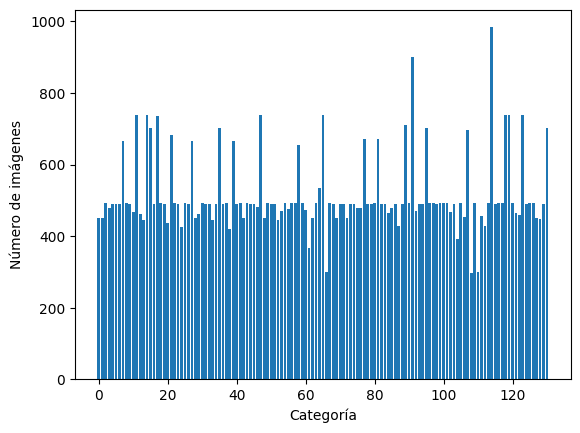

In [13]:
idx, cuentas = np.unique(cat_ent, return_counts=True)
plt.bar(x=idx, height=cuentas)
plt.xlabel('Categoría')
plt.ylabel('Número de imágenes')
plt.show()

Dividimos este conjunto en subconjuntos de entrenamiento y validación usando la función [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) de [scikit-learn](https://scikit-learn.org/). Debido a que la distribución de imágenes por categoría no es uniforme, especificamos que a la partición se realice usando [muestreo estratificado](https://en.wikipedia.org/wiki/Stratified_sampling) pasando la lista de categorías al argumento `stratify`. De esta forma, en los dos subconjuntos tendremos una distribución similar de imágenes por categoría.

In [14]:
from sklearn.model_selection import train_test_split

df_ent, df_val = train_test_split(df_ent,
                                  test_size=0.2,
                                  shuffle=True,
                                  stratify=df_ent['Categoría'])

Comparamos las histogramas de imágenes por categoría en ambos subconjuntos.

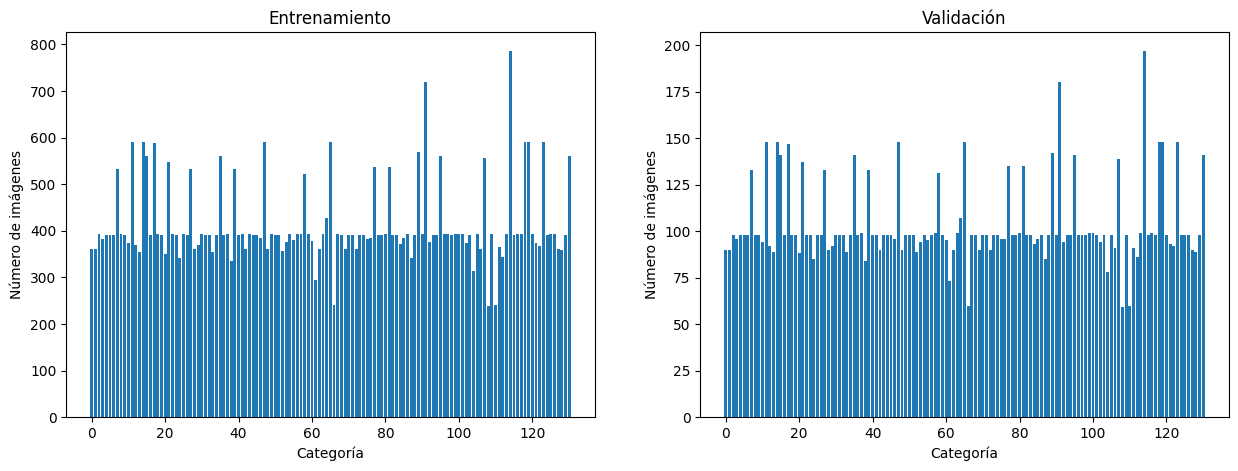

In [15]:
idx_ent, cuentas_ent = np.unique(df_ent['Categoría'], return_counts=True)
idx_val, cuentas_val = np.unique(df_val['Categoría'], return_counts=True)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

axs[0].bar(x=idx_ent, height=cuentas_ent)
axs[0].set_title('Entrenamiento')
axs[0].set_xlabel('Categoría')
axs[0].set_ylabel('Número de imágenes')

axs[1].bar(x=idx_val, height=cuentas_val)
axs[1].set_title('Validación')
axs[1].set_xlabel('Categoría')
axs[1].set_ylabel('Número de imágenes')

plt.show()

Inspeccionémos el número de imágenes y el número de clases en el conjunto de entrenamiento y validación.

In [16]:
print(f'Entrenamiento: \n\tNúmero de clases = {len(ind_a_str)}\n\tNúmero de ejemplos = {len(df_ent)}')
print(f'Validación: \n\tNúmero de ejemplos = {len(df_val)}')

Entrenamiento: 
	Número de clases = 131
	Número de ejemplos = 54153
Validación: 
	Número de ejemplos = 13539


## Clase para Fruits 360
Como podemos observar, el conjunto de datos se encuentra dividido en subconjuntos de entrenamiento y prueba, los cuales están contenidos en los directorios `Training` y `Test`. Estos directorios contienen un subdirectorio por cada clase de fruta y dentro de cada uno de ellos están las imágenes correspondientes.

Vamos a recopilar la ruta de cada una de estas imágenes con su correspondiente etiqueta. Para ello definiremos la subclase de `Dataset` del submódulo `data` de `utils`. Cualquier clase para un conjunto de datos debe incluir la definición de los siguientes tres métodos:
- `__init__`: Constructor de la clase. Usualmente recibe la ruta o archivo con el subconjunto de datos y las transformaciones a aplicarles y crea una estructura para cargar los datos.
- `__getitem__`: Es un método especial donde se define el comportamiento del operador paréntesis. Típicamente en este método se especifica la lectura y transformación de un ejemplo del subconjunto dado un índice de la estructura.
- `__len__`: Este es un método especial que especifica el comportamiento de la función `len` sobre una instancia.

Para nuestra clase, se presupondrá que `__init__` recibirá  como argumentos la ruta del directorio raiz (`Fruit-Images-Dataset`), una cadena de caracteres con el subconjunto que se desea cargar y las transformaciones que se aplicarán a las imágenes. Para listar el contenido de los directorios y subdirectorios se empleará la función `listdir` del módulo [`os`](https://docs.python.org/es/3.10/library/os.html). Dentro de `__init__` se genera un diccionario que mapea la cadena del nombre de cada fruta a un índice y otro de un índice a una cadena de la siguiente manera:

```python
dirs_ent = os.listdir(self.ruta_split)
self.ind_a_str = {i:s for i,s in enumerate(dirs_ent)}
self.str_a_ind = {s:i for i,s in enumerate(dirs_ent)}
```

Posteriormente, se guarda la lista de rutas de todas las imágenes junto con la lista de los correspondientes nombres de frutas o verduras (etiquetas) y la lista de índices (categorías). Esto se realiza iterando primero sobre la lista de subdirectorios y después listando e iterando sobre los archivos de cada subdirectorio y agregando la ruta del archivo de la imagen, el nombre del subdirectorio y su índice a las listas correspondientes.

```python
self.imgs = []
self.etiqs = []
self.cats = []
for e in os.listdir(self.ruta_split): # cada subdirectorio (nombre de fruta)
  for f in os.listdir(self.ruta_split + e): # cada archivo en subdirectorio
    self.imgs.append(self.ruta_split + '/' + e + '/' + f) # guarda ruta completa de imagen
    self.etiqs.append(e) # nombre de fruta
    self.cats.append(self.str_a_ind[e]) # categoría asociada a nombre de fruta
```

El método `__getitem__` recibe como argumento el índice del ejemplo a cargar dentro del subconjunto, lee el archivo de la imagen de disco con la ruta de dicho índice, aplica la transformación especificada como argumento del constructor y regresa un diccionario con los campos `image` para la imagen y `cat` para la categoría correspondiente. Para la lectura de las imágenes se puede emplear cualquier biblioteca, entre las más comúnes se encuentran [Pillow](https://pillow.readthedocs.io/en/stable/), [scikit-image](https://scikit-image.org/) y [OpenCV](https://opencv.org/). Aquí usaremos Pillow, que ofrece la función `open` en el módulo `Image` para leer imágenes en distintos formatos.


```python
def __getitem__(self, idx)
  img = PIL.Image.open(self.imgs[idx])

  if self.transform:
    img = self.transform(img)

  par = {'image': img, 'cat': self.cats[idx]}

  return par
```

Finalmente el método `__len__` no recibe argumentos y regresa el tamaño de la lista de rutas.

```python
def __len__(self):
  return len(self.imgs)
```

La clase completa es:

In [17]:
from torch.utils.data import Dataset
import os
import PIL

class Fruits360(Dataset):
  def __init__(self,
               df,
               raiz,
               transform = None):
    self.df = df
    self.raiz = raiz
    self.transform = transform

  def __getitem__(self, idx):
    img = PIL.Image.open(self.df['Archivo'].iloc[idx])
    cat = self.df['Categoría'].iloc[idx]

    if self.transform:
      img = self.transform(img)

    par = {'image': img, 'cat': cat}
    return par

  def __len__(self):
    return len(self.df)

Instanciamos nuestra clase y cargamos el conjunto de entrenamiento.

In [18]:
dir_raiz = 'Fruit-Images-Dataset'
ds_ent = Fruits360(df_ent, dir_raiz)

Con esta instancia podemos crear un iterador para ir cargando las imágenes.

In [19]:
it_ent = iter(ds_ent)
par_ent = next(it_ent)

print(f'Imagen = {par_ent["image"]}\n'
      f'Categoría = {par_ent["cat"]}\n'
      f'Etiqueta = {ind_a_str[par_ent["cat"]]}')

Imagen = <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=100x100 at 0x7F6CC3D819F0>
Categoría = 108
Etiqueta = Ginger Root


Como podemos ver, es una imagen RGB de $100 \times 100$. Podemos visualizar esta imagen con `matplotlib`.

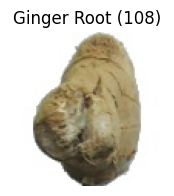

In [20]:
plt.figure(figsize = (2,2))
plt.imshow(par_ent['image'])
plt.title(f'{ind_a_str[par_ent["cat"]]} ({par_ent["cat"]})')
plt.axis('off')
plt.show()

Hacemos lo mismo con el conjunto de prueba.

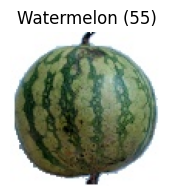

Imagen = <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=100x100 at 0x7F6CC3B1D000>
Categoría = 55
Etiqueta = Watermelon


In [21]:
ds_prueba = Fruits360(df_val, dir_raiz)

it_prueba = iter(ds_prueba)
par_prueba = next(it_prueba)

plt.figure(figsize = (2,2))
plt.imshow(par_prueba['image'])
plt.title(f'{ind_a_str[par_prueba["cat"]]} ({par_prueba["cat"]})')
plt.axis('off')
plt.show()


print(f'Imagen = {par_prueba["image"]}\n'
      f'Categoría = {par_prueba["cat"]}\n'
      f'Etiqueta = {ind_a_str[par_prueba["cat"]]}')

Visualizamos el histograma de imágenes por categoría del conjunto de entrenamiento.

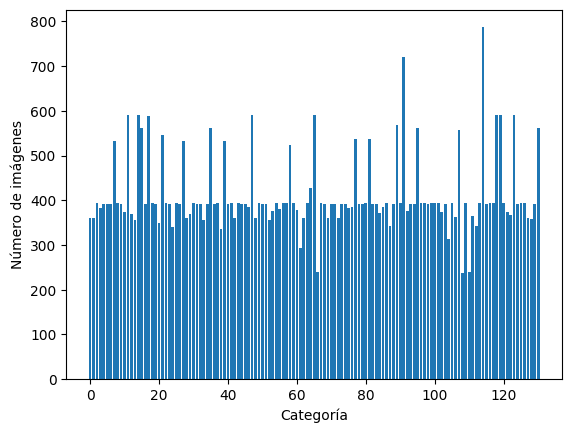

In [22]:
idx, cuentas = np.unique(ds_ent.df['Categoría'], return_counts=True)
plt.bar(x=idx, height=cuentas)
plt.xlabel('Categoría')
plt.ylabel('Número de imágenes')
plt.show()

Comparamos las histogramas de imágenes por categoría en ambos subconjuntos.

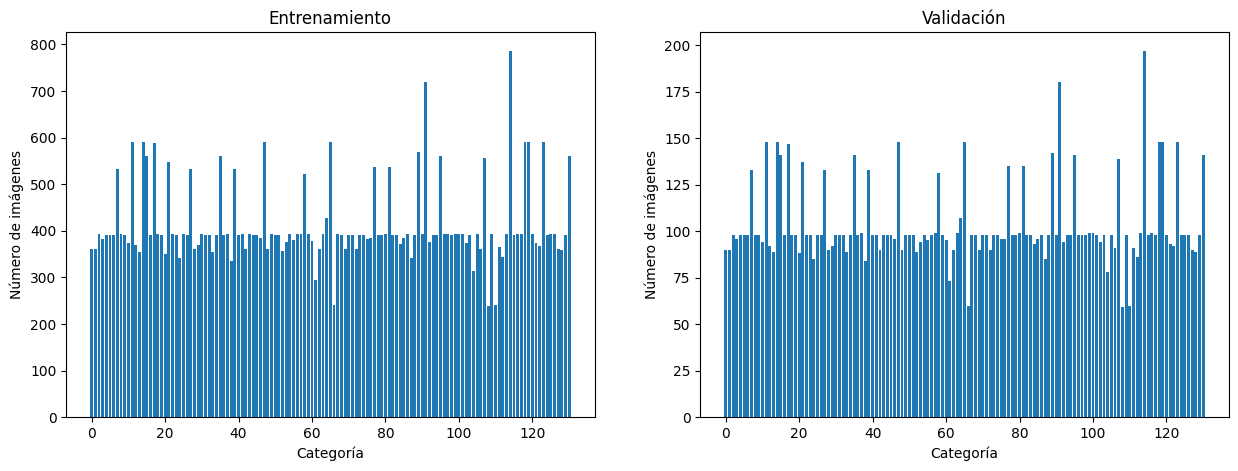

In [23]:
idx_ent, cuentas_ent = np.unique(ds_ent.df['Categoría'], return_counts=True)
idx_val, cuentas_val = np.unique(ds_prueba.df['Categoría'], return_counts=True)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

axs[0].bar(x=idx_ent, height=cuentas_ent)
axs[0].set_title('Entrenamiento')
axs[0].set_xlabel('Categoría')
axs[0].set_ylabel('Número de imágenes')

axs[1].bar(x=idx_val, height=cuentas_val)
axs[1].set_title('Validación')
axs[1].set_xlabel('Categoría')
axs[1].set_ylabel('Número de imágenes')

plt.show()

## Visualización de imágenes
Creamos una función para visualizar múltiples de imágenes con sus correspondientes etiquetas en una rejilla de `matplotlib`. Esta función (`muestra_imagenes`) recibe como argumento un arreglo de NumPy de orden 4 que contiene múltiples imágenes a color con tres canales (RGB) y las etiquetas asociadas a estas. Dependiendo del número de imágenes a mostrar, genera una rejilla con la función `subplots` y muestra cada imagen en un _subplot_ con su correspondiente etiqueta como título.

In [24]:
from math import sqrt

def muestra_imagenes(imgs, etiq):
  t_muestra = imgs.shape[0]
  n_filas = n_cols = int(sqrt(t_muestra))

  fig, ax = plt.subplots(nrows=n_filas, ncols=n_cols, figsize=(2 * n_filas,
                                                               2 * n_cols))
  for i in range(n_filas):
    for j in range(n_cols):
      idx = i * n_filas + j
      ax[i, j].imshow(imgs[idx])
      ax[i, j].axis('off')
      ax[i, j].set_title(etiq[idx])
  plt.tight_layout()
  plt.show()

Cargamos el conjunto de imágenes a mostrar junto con sus correspondientes categorías usando el iterador creado. Debido a que la función `muestra_imagenes` espera un arreglo de NumPy, es necesario convertir las lista de imágenes a esta estructura.

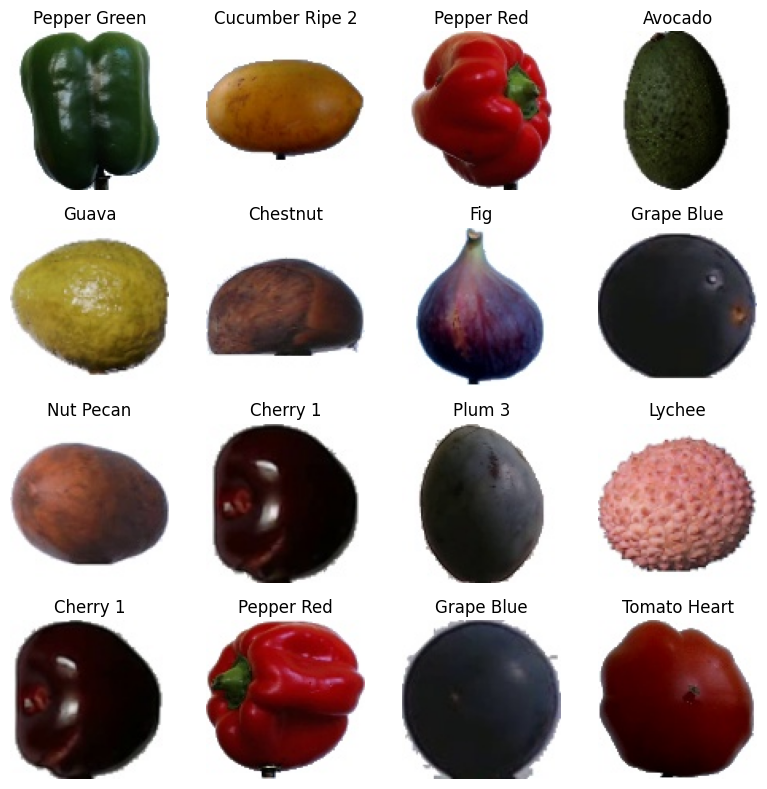

In [25]:
muestras = [next(it_ent) for i in range(N_IMGS_MUESTRA)]
imgs = [np.array(m['image']) for m in muestras]
etiqs = [ind_a_str[m['cat']] for m in muestras]
muestra_imagenes(np.array(imgs), etiqs)

## Transformaciones sobre imágenes
En muchos casos, se aplican transformaciones a los datos leídos. Por ej. se redimensionan las imágenes a un tamaño fijo, se convierten a instancias de `Tensor`, se escalan los valores de los pixeles, etc. Debido a que estas transformaciones son específicas a cada modalidad y tipo de datos, están definidas en bibliotecas que son parte del mismo ecosistema de PyTorch (o externas como [`timm`](https://timm.fast.ai/)) pero separadas de la biblioteca principal. Para imágenes, PyTorch cuenta con la biblioteca [`torchvision`](https://pytorch.org/vision), que incluye clases para extraer y cargar conjuntos de datos, arquitecturas populares de redes neuronales, valores de pesos y sesgos de arquitecturas preentrenadas, transformaciones comunes (algunas de las cuales son subclases de `Module`) y otras clases, funciones y herramientas de visión por computadora.

Debido a que durante el entrenamiento las redes neuronales se alimentan con lotes de imágenes a la vez, es conveniente redimensionarlas para tener un tamaño fijo (por ej. de $H = 64$ y $W = 64$). Podemos redimensionar una imagen de Pillow con la forma $(H, W, C)$ instanciando la clase `Resize` del módulo `transforms` de `torchvision`, donde $H$ es el alto (número de filas), $W$ es el ancho (número de columnas) y $C$ es el la profundidad (número de canales).

In [26]:
from torchvision import transforms as T

redim = T.Resize((T_IMAGEN, T_IMAGEN), antialias=True)

img_pil = par_ent["image"]
print(f'Tamaño original = {img_pil.size}, canales = {img_pil.getbands()}')

rd_img_pil = redim(img_pil)
print(f'Redimensionado = {rd_img_pil.size}, canales = {rd_img_pil.getbands()}')

Tamaño original = (100, 100), canales = ('R', 'G', 'B')
Redimensionado = (64, 64), canales = ('R', 'G', 'B')


También es posible aplicar transformaciones a imágenes representadas como instancias de `Tensor` pero se presupone que tiene la forma $(C, H, W)$ en lugar de $(H, W, C)$. Por lo tanto, no basta con convertir la imagen de Pillow a una instancia de `Tensor`, sino que es necesario permutar las dimensiones usando el método `permute`.

In [27]:
img_thten = th.tensor(img_pil.im).reshape(100, 100, 3).permute(2, 0, 1)
print(f'Tamaño original Tensor de PyTorch = {img_thten.shape}')

redim_img_thten = redim(img_thten)
print(f'Tamaño de Tensor de PyTorch = {redim_img_thten.shape}')

Tamaño original Tensor de PyTorch = torch.Size([3, 100, 100])
Tamaño de Tensor de PyTorch = torch.Size([3, 64, 64])


En varias tareas de visión por computadora es común representar las intensidades de los pixeles con valores de $0$ a $1$ o de $-1$ a $1$. `torchvision` provee la transformación `ToTensor()` que toma una imagen de Pillow o arreglo de NumPy y regresa una instancia de `Tensor` con las dimensiones de $(H, W, C)$ a $(C, H, W)$ y las intensidades representadas con valores de $0$ a $1$.

In [28]:
toten = T.ToTensor()
img_ten = toten(img_pil)

print(f'Forma = {img_ten.shape}, valores = {(img_ten.min(),img_ten.max())}')

Forma = torch.Size([3, 100, 100]), valores = (tensor(0.0510), tensor(1.))


Para aplicar múltiples transformaciones de forma secuencial podemos usar `Sequential` del módulo `nn` de PyTorch o `Compose` del módulo `transforms` de torchvision. Sin embargo, toma en cuenta que `Sequential` solo permite instancias de subclases de `Module`, mientras que `Compose` permite instancias de otras clases (siempre y cuando definan los métodos requeridos). Por otro lado, `Compose` no es compatible con [TorchScript](https://pytorch.org/docs/stable/jit.html) mientras que `Sequential` sí lo es.

In [29]:
composed = T.Compose([T.Resize(T_IMAGEN),
                      T.ToTensor()])
img_tr = composed(img_pil)
print(f'Forma = {img_tr.shape}, valores = {(img_tr.min(),img_tr.max())}')

Forma = torch.Size([3, 64, 64]), valores = (tensor(0.1059), tensor(1.))


Debido a que `ToTensor` no es subclase de `Module`, no es posible usarla con `Sequential`. Además, al requerir subclases de `Module`, se espera recibir instancias de `Tensor` como argumento. Por lo mismo, para componer las mismas transformaciones con `Sequential` es necesario crear una subclase para convertir las imágenes a instancias de `Tensor` o hacerlo antes de pasarlo a la composición de transformaciones.

In [30]:
class MiToTensor(nn.Module):
  def __init__(self):
    super(MiToTensor, self).__init__()

  def forward(self, x):
    h = x.height
    w = x.width
    c = len(x.getbands())

    x = th.tensor(x.im, dtype=th.float64)
    x = x.reshape(h, w, c)
    x = x.permute(2, 0, 1)
    return x / 255

seqcomp = nn.Sequential(MiToTensor(),
                        T.Resize(64, antialias=True))
img_tr = seqcomp(img_pil)
print(f'Forma = {img_tr.shape}, valores = {(img_tr.min(),img_tr.max())}')

Forma = torch.Size([3, 64, 64]), valores = (tensor(0.1037, dtype=torch.float64), tensor(1.0000, dtype=torch.float64))


## Acrecentamiento de datos
Una estrategia sencilla pero a la vez efectiva para reducir el sobreajuste es el [acrecentamiento de datos](https://en.wikipedia.org/wiki/Data_augmentation), que consiste en generar versiones modificadas de los datos disponibles. Para el caso de clasificación de imágenes, esto puede lograrse aplicando transformaciones que conserven las correspondientes etiquetas (por ej. aleatoriamente voltear las imágenes horizontalmente/verticalmente, recortarlas, rotarlas, etc.). `torchvision` cuenta con varias de estas transformaciones, como `RandomHorizontalFlip` y `RandomResizedCrop` para voltear y para recortar una imagen de forma aleatoria.

In [31]:
tr_ent = T.Compose([T.RandomResizedCrop(T_IMAGEN,
                                        scale = (0.85, 1.0),
                                        antialias = True),
                    T.RandomHorizontalFlip(),
                    T.ToTensor()])

El acrecentamiento usualmente solo se realiza con los datos de entrenamiento, por lo que tenemos dos secuencias de transformaciones:

In [32]:
tr_prueba = T.Compose([T.Resize(T_IMAGEN, antialias=True),
                       T.ToTensor()])

Lo más común es pasar las transformaciones como argumento
del constructor del conjunto como sigue:

```python
ds_ent = Fruits360(dir_raiz, transform = data_transform)
```

Sin embargo, como ya contamos con instancias para los subconjuntos de entrenamiento y prueba, podemos simplemente modificar el valor de la variable `transform`:

In [33]:
ds_ent.transform = tr_ent
ds_prueba.transform = tr_prueba

Visualizamos algunas imágenes con estas transformaciones.

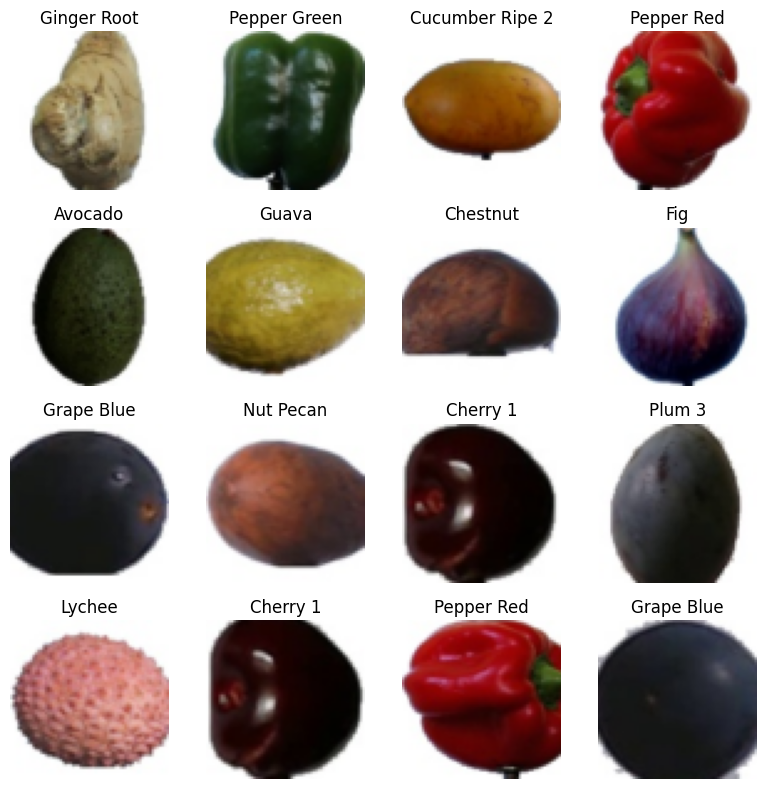

In [34]:
it = iter(ds_ent)
muestras = [next(it) for i in range(N_IMGS_MUESTRA)]
imgs = [np.array(m['image'].permute(1, 2, 0)) for m in muestras]
etiqs = [ind_a_str[m['cat']] for m in muestras]

muestra_imagenes(np.array(imgs), etiqs)

Para el caso del subconjunto de validación, lo hacemos desde el constructor:

In [35]:
tr_val = T.Compose([T.Resize(64, antialias=True),
                    T.ToTensor()])
ds_val = Fruits360(df_val, dir_raiz, transform = tr_val)

## Cargadores de datos con `DataLoader`
Para facilitar la creación y carga de lotes PyTorch ofrece la clase `DataLoader`. El constructor de esta clase recibe la instancia del conjunto de datos, el tamaño del lote (`batch_size`) y si se deben permutar aleatoriamente los datos antes de iterar (`shuffle = True`).

In [36]:
from torch.utils.data import DataLoader
from torchvision import transforms as T

ent_dl = DataLoader(ds_ent,
                    batch_size=T_LOTE,
                    shuffle=True)

it_entdl = iter(ent_dl)
lote = next(it_entdl)
print(f'Imágenes = {lote["image"].shape}, Categorías = {lote["cat"].shape}')

Imágenes = torch.Size([32, 3, 64, 64]), Categorías = torch.Size([32])


Visualizamos un lote completo de imágenes.

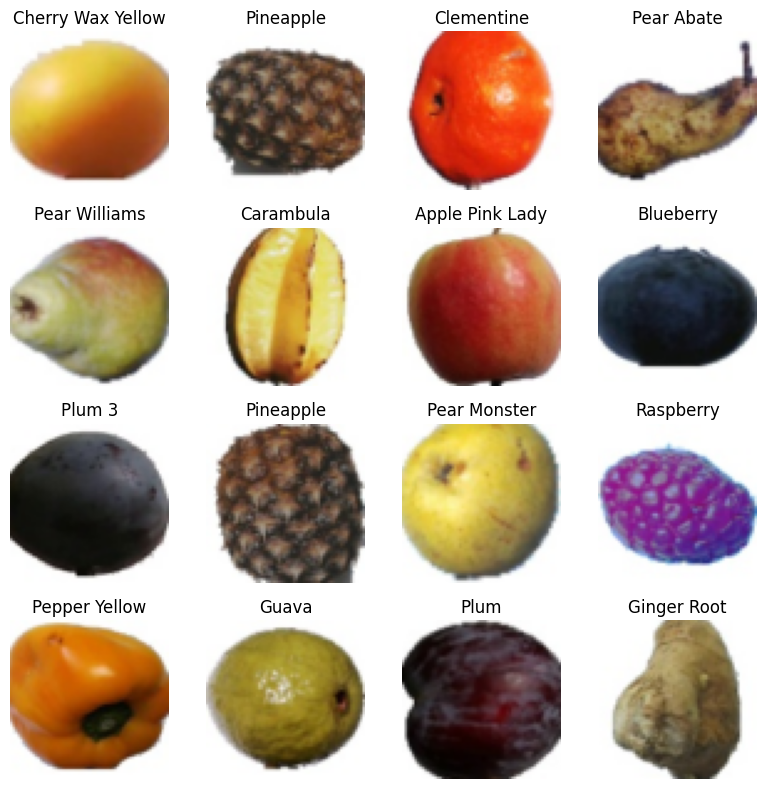

In [37]:
imgs = lote['image'][:N_IMGS_MUESTRA]
etiqs = [ind_a_str[c] for c in lote['cat'][:N_IMGS_MUESTRA].numpy()]
muestra_imagenes(imgs.permute(0, 2, 3, 1).numpy(), etiqs)

Durante el entrenamiento usualmente se va iterando lote por lote en un bucle hasta recorrer todo el conjunto de datos. Por ej.: para cargar los primeros 10 lotes del conjunto:

In [38]:
for i,l in enumerate(ent_dl):
  if i > 10:
    break
  print(f'Lote {i}: Imágenes = {l["image"].shape}, Categorías = {l["cat"].shape}')

Lote 0: Imágenes = torch.Size([32, 3, 64, 64]), Categorías = torch.Size([32])
Lote 1: Imágenes = torch.Size([32, 3, 64, 64]), Categorías = torch.Size([32])
Lote 2: Imágenes = torch.Size([32, 3, 64, 64]), Categorías = torch.Size([32])
Lote 3: Imágenes = torch.Size([32, 3, 64, 64]), Categorías = torch.Size([32])
Lote 4: Imágenes = torch.Size([32, 3, 64, 64]), Categorías = torch.Size([32])
Lote 5: Imágenes = torch.Size([32, 3, 64, 64]), Categorías = torch.Size([32])
Lote 6: Imágenes = torch.Size([32, 3, 64, 64]), Categorías = torch.Size([32])
Lote 7: Imágenes = torch.Size([32, 3, 64, 64]), Categorías = torch.Size([32])
Lote 8: Imágenes = torch.Size([32, 3, 64, 64]), Categorías = torch.Size([32])
Lote 9: Imágenes = torch.Size([32, 3, 64, 64]), Categorías = torch.Size([32])
Lote 10: Imágenes = torch.Size([32, 3, 64, 64]), Categorías = torch.Size([32])


Creamos los cargadores para los subconjuntos de validación y prueba, los cuales no se permutan aleatoriamente. No es necesario que el tamaño del lote sea igual al de entrenamiento para estos subconjuntos y, en general, la elección del tamaño del lote para los subconjuntos de validación y prueba no afecta el desempeño en la tarea, solo la rapidez con que sea realizan las operaciones. Debido a que comúnmente se va monitoreando el desempeño en cada época sobre todo el subconjunto de validación, es conveniente que sea lo más grande posible; para este ejemplo eligiremos el mismo que el de entrenamiento. Para el subconjunto de prueba, eligiremos un tamaño de 1.

In [39]:
val_dl = DataLoader(ds_val,
                    batch_size=T_LOTE,
                    shuffle=False)

prueba_dl = DataLoader(ds_prueba,
                       batch_size=1,
                       shuffle=False)

Visualizamos un lote de imágenes del subconjunto de validación.

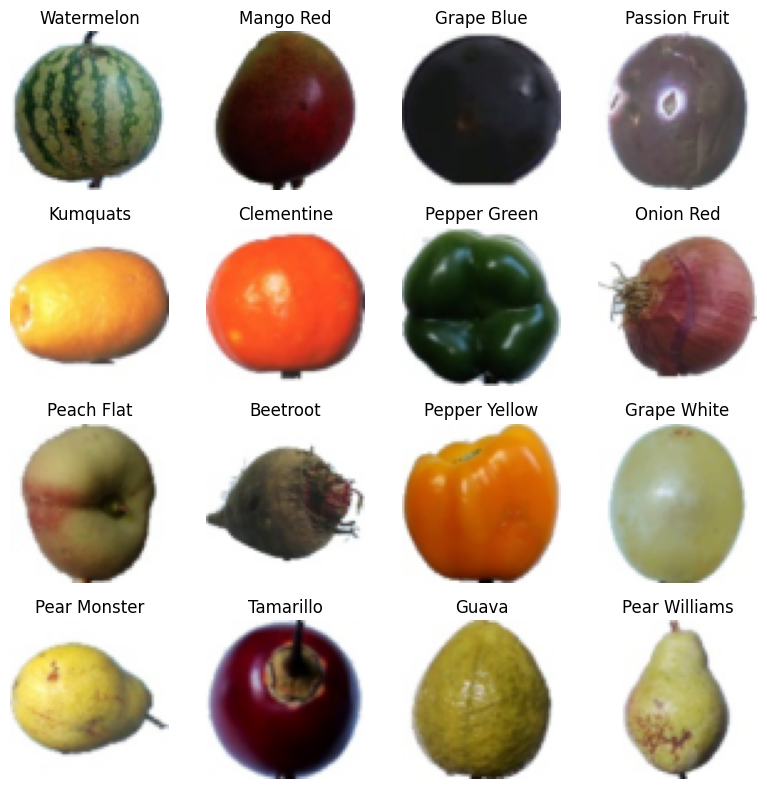

In [40]:
it_valdl = iter(val_dl)
lote = next(it_valdl)
imgs = lote['image'][:N_IMGS_MUESTRA]
etiqs = [ind_a_str[c] for c in lote['cat'][:N_IMGS_MUESTRA].numpy()]
muestra_imagenes(imgs.permute(0, 2, 3, 1).numpy(), etiqs)

Finalmente, hacemos lo propio con un lote de imágenes del subconjunto de prueba.

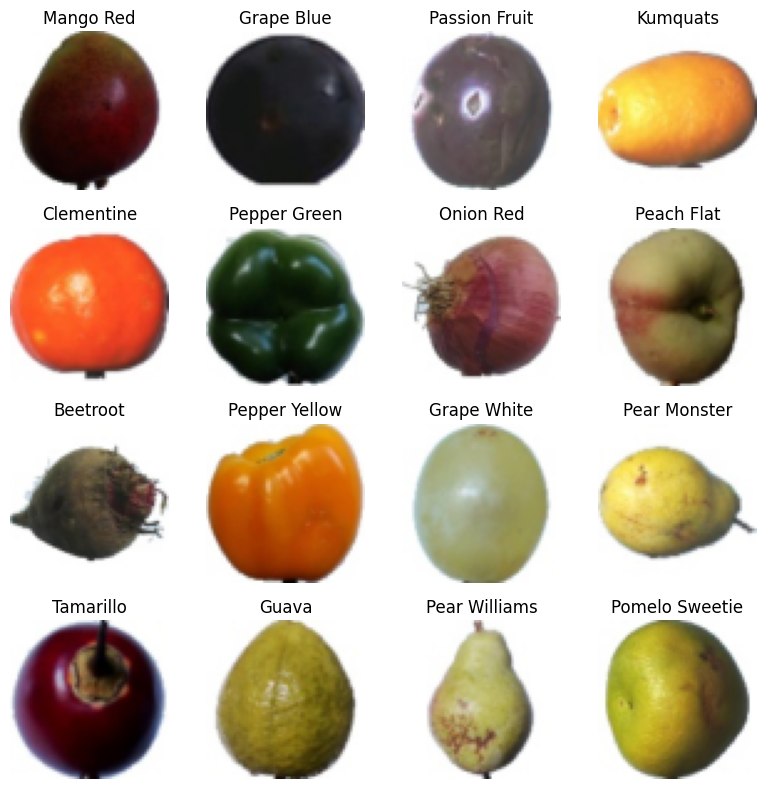

In [41]:
it_pruebadl = iter(prueba_dl)

muestras = [next(it_prueba) for i in range(N_IMGS_MUESTRA)]
imgs = [np.array(m['image'].permute(1, 2, 0)) for m in muestras]
etiqs = [ind_a_str[m['cat']] for m in muestras]
muestra_imagenes(np.array(imgs), etiqs)